In [1]:
%matplotlib inline
import networkx as nx


# 第 3 章

目次：

1. [ハブを見つける](#Finding-hubs)
2. [中心性分布](#Centrality-distributions)
3. [頑健性のテスト](#Testing-robustness)

## 1.ハブを見つける

多くの場合、ネットワークを見るとき、重要な定義のために、最も「重要な」ノードを見つけたい。中心性の最も基本的な尺度は、*次数*、つまりノードに接続されたリンクの数である。

Enron の幹部の電子メールのグラフを見てみよ。


Name: 
Type: Graph
Number of nodes: 143
Number of edges: 623
Average degree:   8.7133


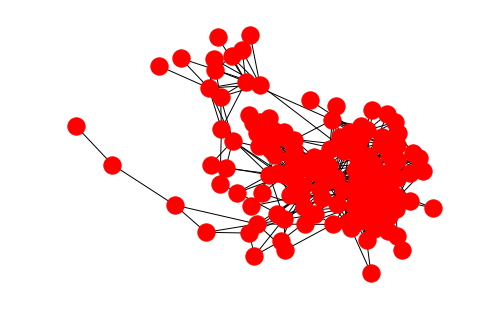

In [2]:
G = nx.read_edgelist('../datasets/ia-enron-only/ia-enron-only.edges', nodetype=int)
print(nx.info(G))
nx.draw(G)


### 警告: デフォルトでは、 `nx.read_edgelist` はノード名が文字列であると仮定する

エッジのリストは、グラフを格納するための単純なプレーン・テキスト形式である。この単純なファイル形式にはデータ型に関する情報が含まれていないため、すべてのノード名はデフォルトで文字列と見なされる。この例のように、ノード名が整数で指定されたい場合、ノード名との混乱を避けるために `nodetype=int` キーワード引数を指定する必要がある。

### 余談: `max` 関数

次数が最も高いノードを見つけるために、Python の組み込み `max` 関数を使用する。

まず、 `max` 関数が何をするかを思い出せたい。最も基本的なものとして、 `max` 関数はシーケンス内の「最大の」アイテムを返すことである。


In [3]:
max([1,2,3,4,5])

5


しかし、「最大の」アイテムが常に明白であるとは限らない。


In [4]:
max(['apple', 'grape', 'carrot'])

'grape'


`grape`他の選択肢より優れているのはなぜ？文字列のデフォルトのソートは辞書順 (基本的にはアルファベット順) であるためだった。このデフォルトの順序付けが必要ない場合は、アイテムを比較する方法を Python に指示する *key* 関数を指定したい。


In [5]:
max(['apple', 'grape', 'carrot'], key=len)

'carrot'


アイテムを長さで比較しているため、 `carrot` が最大の要素になる。

### 次数が最大のノードを見つける

`max` 関数を適用して、いくつかの基準に従って最大ノードを取得できる。この場合、次数でノードを比較すれば、最大次数のノードを取得できる。


In [6]:
highest_degree_node = max(G.nodes, key=G.degree)
highest_degree_node

105

In [7]:
G.degree(highest_degree_node)

42


したがって、ノード `105` には 42 個のエッジが接続されていることがわかる。その計算をもう少し詳しく見せたい。

前述の文は、*キー*関数 `G.degree` に渡されたときに最高値を与える `G.nodes` からのアイテムが必要であることを `max` 関数に伝えている。

`G.degree` は関数であるため、この文が正常に動く。中間性などの他の中心性の尺度は、すべてのノードの中心性の値を一度に生成し、 `dict` を返す。この場合、追加の手順が必要である。


In [8]:
betweenness = nx.centrality.betweenness_centrality(G)
highest_betweenness_node = max(G.nodes, key=betweenness.get)
highest_betweenness_node

105

In [9]:
betweenness[highest_betweenness_node]

0.19400604344556296


次の場合、エラーがスローされることに注意させたい。


In [10]:
max(G.nodes, key=betweenness)

TypeError: 'dict' object is not callable


これは、 `key`引数に関数を提供する必要がある一方、 `betweenness` という辞書を与えたためである。これを回避するには、dict の `get` メソッドを使用したい。



## 2. 中心性分布

ネットワークで最も中心的なノードを見つけたかもしれないが、多くの場合、すべてのノードの中心性に関する情報を要約したいと考えている。たとえば、最大次数に加え、ネットワーク中心性の平均値と中央値が必要になることがよくある。

この情報を要約するための最初のステップは、グラフ内のすべての中心性の値のシーケンスを取得することである。ノード名はもう気にせず、数のシーケンスが必要なだけである。次数の例から始めたい。


In [11]:
degree_sequence = [G.degree(n) for n in G.nodes]


このシーケンスの平均と中央値を取得するには、Python の組み込み `statistics` モジュールを使用できる。


In [12]:
import statistics

print('Mean degree:', statistics.mean(degree_sequence))
print('Median degree:', statistics.median(degree_sequence))

Mean degree: 8.713286713286713
Median degree: 8



ネットワーク全体に対して一度に計算され、辞書を返す他の中心性の尺度については、辞書の `.values()` を使用できる。


In [13]:
betweenness = nx.centrality.betweenness_centrality(G)
betweenness_sequence = list(betweenness.values())

print('Mean betweenness:', statistics.mean(betweenness_sequence))
print('Median betweenness:', statistics.median(betweenness_sequence))

Mean betweenness: 0.013950388838012454
Median betweenness: 0.0037492834763570323



### 分布のプロット

*ヒストグラム*を使用して、中心性の値のシーケンスをグラフィカルに表したい。基本的な形式では、ヒストグラムは x 軸に次数の値をプロットし、y 軸にその次数を持つノードの数をプロットする。このカウントを行うために、Python の `collections.Counter` を利用できる。


In [14]:
from collections import Counter

degree_counts = Counter(degree_sequence)
degree_counts

Counter({1: 6,
         2: 16,
         3: 9,
         4: 11,
         5: 8,
         6: 7,
         7: 9,
         8: 6,
         9: 16,
         10: 9,
         11: 10,
         12: 5,
         13: 3,
         14: 6,
         15: 3,
         16: 5,
         17: 5,
         18: 3,
         19: 2,
         20: 1,
         23: 1,
         30: 1,
         42: 1})


返される `Counter` オブジェクトは `dict` のようなもので、カウントされた項目とシーケンスに表示された回数をペアする。

この基本的なヒストグラム・プロットでは、シーケンス内の最小度と最大度の間のすべての整数の x 値が必要である。 `degree_counts.keys()` は、次数シーケンスで見られるすべての個別の値を提供することに注意させたい。また、適切なエンドポイントを含めたいため、以下の `range` に +1 が必要であることに注意させたい。


In [15]:
min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())

plot_x = list(range(min_degree, max_degree + 1))


y 値は、次数シーケンスで各 x 値を数えた回数である。シーケンスに表示されない次数、たとえば、32 は上記の `degree_counts` に表示されないこと、の値を 0 とカウントするために、デフォルト値で `.get` メソッドを使用することで、`degree_counts.get(32, 0)`を 0 に返してもらいたい。


In [16]:
plot_y = [degree_counts.get(x, 0) for x in plot_x]


プロットを行うには、Matplotlib の `pyplot` モジュールを使用する。


<Container object of 42 artists>

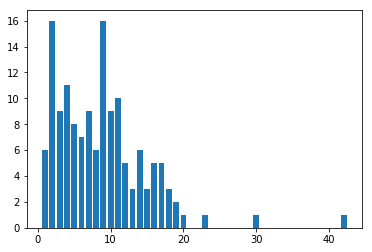

In [17]:
import matplotlib.pyplot as plt

plt.bar(plot_x, plot_y)


### ヒストグラムのビニング

快適に表示できるよりも多くの x 値がある場合、または中間中心性の場合のように中心性の尺度が離散的でない場合は、ヒストグラムの「ビニング」が用いられる。これは、 *bins* と呼ばれる互いに素な間隔のシーケンスを定義し、そのような各ビンに入る値の数をカウントするだけである。最も単純なケースでは、matplotlib.pyplot の `hist` 関数に必要なビンの数を伝えるだけで、ビニングが実行される。


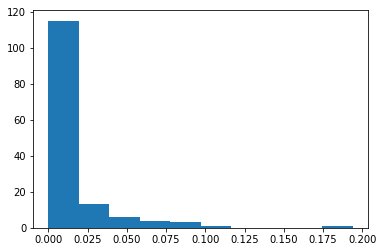

In [18]:
counts, bins, patches = plt.hist(betweenness_sequence, bins=10)


必要に応じて、返された `bins` と `counts` を調査できる。


In [19]:
bins

array([0.        , 0.0194006 , 0.03880121, 0.05820181, 0.07760242,
       0.09700302, 0.11640363, 0.13580423, 0.15520483, 0.17460544,
       0.19400604])

In [20]:
counts

array([115.,  13.,   6.,   4.,   3.,   1.,   0.,   0.,   0.,   1.])


これらから、0 から 0.0194006 の間に 115 個の値、0.194006 から 0.3880121 の間に 13 個の値があることなどがわかる。



## 3. 頑健性のテスト

ネットワーク内のノードの相対的な「重要性」について考えるもう 1 つの方法は、特定のノードを削除した場合にネットワーク構造がどの程度損傷するかを測定することである。実際には、ノードの削除は、ソーシャル・ネットワークから離れる人、転職して電子メールがネットワークから削除される人、インターネット・ルーターが攻撃されたり過負荷になったりダウンしたりすることなどである可能性があげられる。

大まかに、ランダム障害と標的型攻撃の 2 種類のネットワーク損傷を考えたい。ランダム障害では、削除するノードがランダムに選択される一方、標的型攻撃では、いくつかの基準に基づいてノードが削除される。たとえば、次数中心性の降順でノードが削除指される。

### 連結成分

「損傷」を測定するために、ネットワークの最大の連結成分 (*コア*と呼ばれることもある) のサイズを測定したい。まず、`nx.connected_components` は最大のものから始めて、一つずつ連結成分を与えるジェネレータであることを察する。


In [21]:
nx.connected_components(G)

<generator object connected_components at 0x7f7d85601f68>


多くの場合、コアまたは最大の接続コンポーネントのみが必要なため、 `next`関数を使用して、ジェネレーターから最初の項目だけを取得すればいい。各コンポーネントは、一連のノード名として提供されている。


In [22]:
core = next(nx.connected_components(G))
core

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143}


したがって、このセットの `len` がこの連結成分内のノードの数を示す。


In [23]:
len(core)

143


すべての連結成分が必要な場合は、それらのリストを取得できる。


In [24]:
components = list(nx.connected_components(G))


このリストの長さはグラフの連結成分の数である。


In [25]:
len(components)

1


### ランダム障害

破壊的なプロセスに関与するときはいつでも、元の状態に簡単に戻れるように、攻撃する前に、まずネットワークのグラフのコピーを作成したい。


In [26]:
C = G.copy()


ランダムな障害をシミュレートするために、いくつかのノード名をランダムに選択し、グラフから削除する。 `random.sample` を使用して、一度に複数のノードを削除できる。ランダムにサンプリングするノード名の `list` を作成する必要があることに注意させたい。


In [27]:
import random

nodes_to_remove = random.sample(list(C.nodes), 2)
C.remove_nodes_from(nodes_to_remove)


完全なシミュレーションは、ネットワークの新しいコピーから始めて、次の手順：

1. ネットワークのコアのサイズを測定し、元のネットワークのコアのサイズと比較する
2. M 個のノードをランダムに選択して削除する
3. ノード数が M 個未満になるまで繰り返す

に従う。

このプロセスに必要なステップ数から M を決定したい。約 25 ステップが適切なはずなので、次のように決める。


In [28]:
number_of_steps = 25
M = G.number_of_nodes() // number_of_steps
M

5


従って、`range` を使用して、各ステップで削除されたノードの総数のシーケンスを生成できる。


In [29]:
num_nodes_removed = range(0, G.number_of_nodes(), M)


ループはかなり単純で、各ステップで、コアに残っているノードの割合を記録し、プロットするだけである。


In [30]:
N = G.number_of_nodes()
C = G.copy()
random_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = next(nx.connected_components(C))
    core_proportion = len(core) / N
    random_attack_core_proportions.append(core_proportion)
    
    # If there are more than M nodes, select M nodes at random and remove them
    if C.number_of_nodes() > M:
        nodes_to_remove = random.sample(list(C.nodes), M)
        C.remove_nodes_from(nodes_to_remove)

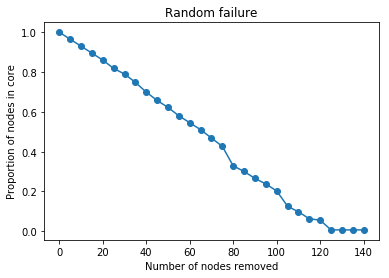

In [31]:
plt.title('Random failure')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o')


#### 標的型攻撃

標的型攻撃のシミュレーションは似ているが、ランダムに選択する代わりに、各ステップで M 個の最も中心的なノードを選択する。これを達成するには、最上位の M ノードを取得できる `max` 関数のようなものが必要となる。 Python の `sorted` 関数を `max` と同様の方法で使用して、最初にノードを中心度で降順（逆順とも呼ばれる）に並べ替えることができる。次数でソートしたら、リストの最初の M ノードを取得する。


In [32]:
nodes_sorted_by_degree = sorted(G.nodes, key=G.degree, reverse=True)
top_degree_nodes = nodes_sorted_by_degree[:M]
top_degree_nodes

[105, 17, 95, 48, 132]


それを念頭に置いて、ループはかなり似ている。ここですべてのピースをまとめてみたい。


In [33]:
N = G.number_of_nodes()
number_of_steps = 25
M = N // number_of_steps

num_nodes_removed = range(0, N, M)
C = G.copy()
targeted_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = next(nx.connected_components(C))
    core_proportion = len(core) / N
    targeted_attack_core_proportions.append(core_proportion)
    
    # If there are more than M nodes, select top M nodes and remove them
    if C.number_of_nodes() > M:
        nodes_sorted_by_degree = sorted(C.nodes, key=C.degree, reverse=True)
        nodes_to_remove = nodes_sorted_by_degree[:M]
        C.remove_nodes_from(nodes_to_remove)

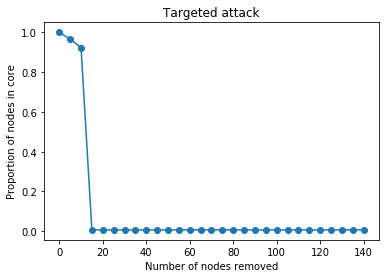

In [34]:
plt.title('Targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='o')


ご覧のとおり、効果はランダム障害に比べて劇的である。グラフ内の比較的少数の中央ノードを削除するだけで、ネットワークは完全に切断される。

Pyplot は、2 つの方法で攻撃を行った結果の曲線を同じプロットに描くことができる。


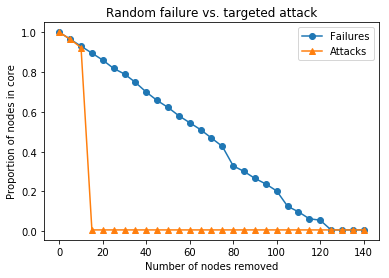

In [35]:
plt.title('Random failure vs. targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o', label='Failures')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='^', label='Attacks')
plt.legend()